# **TAREFA - MODELAGEM DE CLASSIFICAÇÃO**
### *Case: Pedidos de Refeições* (base de dados: Pedidos_Refeicoes.txt)
##### Uma empresa de tecnologia, atuante no ramo de entrega de refeições solicitadas por aplicativo, deseja entender quais os perfis de consumidores que declaram ser influenciados pela nota de avaliação dos restaurantes no momento de realizarem seu pedido. Para isso, coletaram informações transacionais e realizaram uma pesquisa com clientes que fizeram algum pedido nos últimos 30 dias.
##### As seguintes variáveis estão disponíveis:
* *ID_Respondente:* Código identificador do respondente da pesquisa
* *Idade:* Idade do cliente
* *Genero:* Gênero do cliente
* *Estado_Civil:* Estado civil do cliente
* *Ocupacao_Usual:* Ocupação usual do cliente
* *Renda_Mensal_Familiar:* Renda mensal familiar declarada pelo cliente
* *Grau_Educacao:* Grau de escolaridade do cliente
* *Refeicao_Mais_Frequente:* Tipo de refeição mais frequente dos pedidos realizados no último ano: café da manhã, almoço, jantar ou lanches
* *Compras_Saudaveis:* Indicação de se já fez compra de comida saudável no último ano (sim ou não)
* *Reclamacao_Atraso:* Indicação de se já fez alguma reclamação por atraso na entrega no último ano (sim ou não)
* *Avaliacao_Media_Anterior:* Nota média de avaliação dos restaurantes nos quais o cliente realizou pedidos no último ano
* *Influenciado_Por_Nota:* Resposta do cliente na pesquisa sobre ser influenciado pela nota do restaurante (sim ou não)

##### Realize uma análise exploratória da base de dados, de forma univariada e bivariada, cruzando cada *feature* com o *target*. Em seguida, utilize diferentes algoritmos de classificação para predizer a probabilidade de um cliente ser influenciado pela nota de avaliação dos restaurantes. Proponha um modelo final, como base na estimativa do seu desempenho em dados apartados, e interprete a força e sentido de discriminância de suas variáveis. Atente-se às boas práticas de modelagem vistas em aula.

##### **Entregável**: notebook do Python (extensão .ipynb) já compilado, subdividido de acordo com as seções abaixo. Comente os resultados de todas as análises conduzidas.


### CARREGAMENTO DE BIBLIOTECAS

In [ ]:
! pip install shap

In [ ]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler                       # Balanceamento de classes
from sklearn.compose import make_column_selector, ColumnTransformer          # Transformação e seleção de variáveis
from sklearn.preprocessing import StandardScaler, OneHotEncoder              # Padronização de quantitativas e criação de dummies para qualitativas
from sklearn.linear_model import LogisticRegression                          # Regressão logística
from sklearn.tree import DecisionTreeClassifier                              # Árvore de decisão
from sklearn.ensemble import RandomForestClassifier                          # Floresta aleatória
from sklearn.ensemble import AdaBoostClassifier                              # AdaBoost
from sklearn.ensemble import GradientBoostingClassifier                      # Gradient boosting
from xgboost import XGBClassifier                                            # XGBoost
from lightgbm import LGBMClassifier                                          # LightGBM
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate   # Validação cruzada
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV         # Otimização de hiperparâmetros via grid search e random search
import shap                                                                  # Interpretabilidade de modelos de ML

# configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

### LEITURA DA BASE DE DADOS

In [ ]:
dados = pd.read_table("Pedidos_Refeicoes.txt",
                      decimal = ".",
                      sep = "\t")

In [ ]:
display(dados)

,ID_RESPONDENTE,IDADE,GENERO,ESTADO_CIVIL,OCUPACAO_USUAL,RENDA_MENSAL_FAMILIAR,GRAU_EDUCACAO,REFEICAO_MAIS_FREQUENTE,COMPRAS_SAUDAVEIS,RECLAMACAO_ATRASO,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
0,1,29,Feminino,Casado,Sem Ocupacao,5300,Graduacao,Almoco,Sim,Sim,4.5,1
1,2,37,Masculino,Casado,Empregado CLT,28100,Pos-Graduacao,Lanches,Sim,Sim,4.5,0
2,3,36,Feminino,Casado,Empregado CLT,14000,Graduacao,Cafe da manha,Nao,Nao,4.2,1
3,4,28,Masculino,Casado,Autonomo,10900,Ensino Fund./Medio,Cafe da manha,Nao,Nao,4.5,0
4,5,31,Feminino,Casado,Estudante,8100,Graduacao,Jantar,Nao,Nao,4.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2739,2740,27,Masculino,Solteiro,Sem Ocupacao,3300,Sem Instrucao,Jantar,Nao,Nao,4.2,1
2740,2741,40,Masculino,Casado,Empregado CLT,3900,Graduacao,Almoco,Nao,Nao,4.6,1
2741,2742,34,Masculino,Casado,Empregado CLT,8700,Sem Instrucao,Almoco,Nao,Nao,4.7,1
2742,2743,48,Feminino,Casado,Empregado CLT,6200,Pos-Graduacao,Lanches,Sim,Nao,4.6,0


In [ ]:
pd.DataFrame(dados.dtypes)

,0
ID_RESPONDENTE,int64
IDADE,int64
GENERO,object
ESTADO_CIVIL,object
OCUPACAO_USUAL,object
RENDA_MENSAL_FAMILIAR,int64
GRAU_EDUCACAO,object
REFEICAO_MAIS_FREQUENTE,object
COMPRAS_SAUDAVEIS,object
RECLAMACAO_ATRASO,object


In [ ]:
dados.isnull().sum()

,0
ID_RESPONDENTE,0
IDADE,0
GENERO,0
ESTADO_CIVIL,0
OCUPACAO_USUAL,0
RENDA_MENSAL_FAMILIAR,0
GRAU_EDUCACAO,0
REFEICAO_MAIS_FREQUENTE,0
COMPRAS_SAUDAVEIS,0
RECLAMACAO_ATRASO,0


### ANÁLISE EXPLORATÓRIA UNIVARIADA

In [ ]:
dados.describe()

,ID_RESPONDENTE,IDADE,RENDA_MENSAL_FAMILIAR,AVALIACAO_MEDIA_ANTERIOR,INFLUENCIADO_POR_NOTA
count,2744.000000,2744.000000,2744.000000,2744.000000,2744.000000
mean,1372.500000,32.576895,8145.007289,4.584220,0.682945
std,792.268894,10.889525,4524.974711,0.186558,0.465414
min,1.000000,18.000000,800.000000,4.000000,0.000000
25%,686.750000,25.000000,4800.000000,4.500000,0.000000
50%,1372.500000,30.000000,7300.000000,4.600000,1.000000
75%,2058.250000,38.000000,10700.000000,4.700000,1.000000
max,2744.000000,86.000000,28100.000000,4.900000,1.000000


Podemos observar a ausência de valores nulos e os dados estatísticos como máximo, minímo, desvio padrão e percentis das variáveis quantitativas.

### ANÁLISE EXPLORATÓRIA BIVARIADA

Podemos verificar que:

- IDADE: A idade mediana e a dispersão são semelhantes em ambos os grupos, com alguns outliers mais velhos.
- RENDA_MENSAL_FAMILIAR: O grupo influenciado tem uma renda mediana um pouco maior em comparação com o grupo não influenciado.
- AVALIACAO_MEDIA_ANTERIOR: O grupo influenciado tem uma "avaliação média anterior" ligeiramente superior à do grupo influenciado, com o grupo não influenciado apresentando maior variabilidade nos dados.

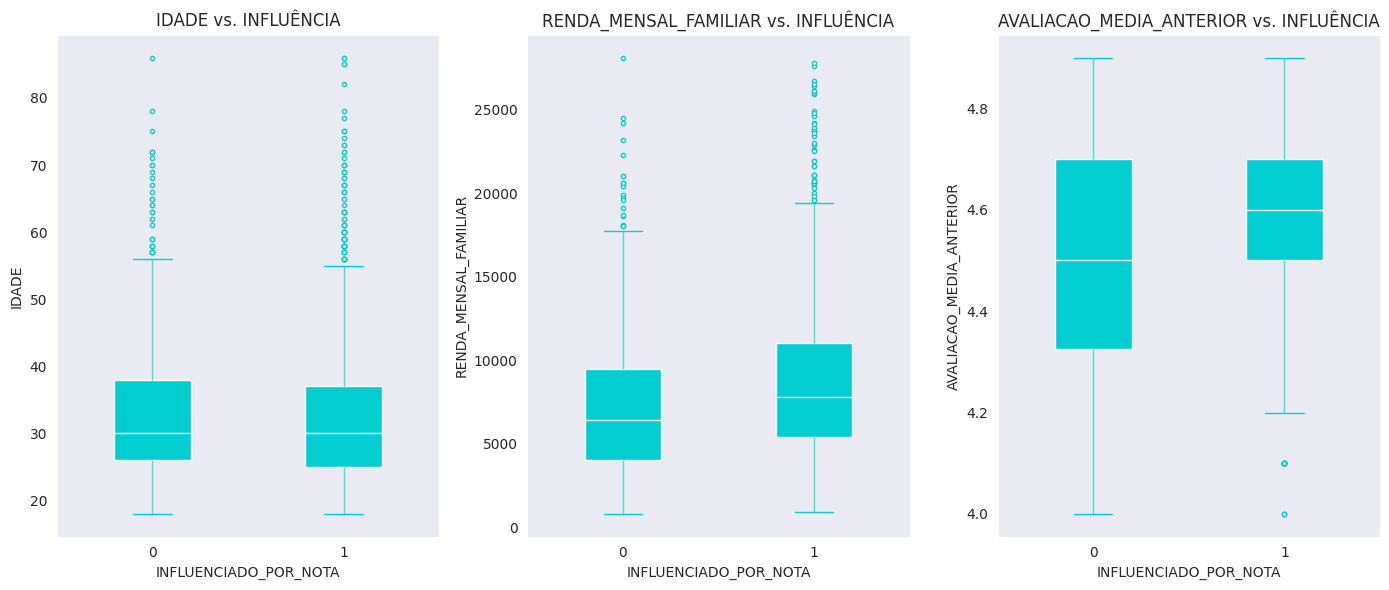

In [ ]:
# Gráfico de boxplots: variáveis explicativas quantitativas versus a influência por nota
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 6))

variaveis = ['IDADE', 'RENDA_MENSAL_FAMILIAR', 'AVALIACAO_MEDIA_ANTERIOR']

for ax, variavel in zip(axes.flat, variaveis):

  sns.boxplot(y = variavel,
              x = 'INFLUENCIADO_POR_NOTA',
              data = dados,
              width = 0.4,
              boxprops = {'facecolor':'darkturquoise', 'edgecolor':'white'},
              whiskerprops = {'color':'turquoise'},
              capprops     = {'color': 'darkturquoise'},
              medianprops  = {'color':'white'},
              flierprops   = {'markerfacecolor': 'white', 'markeredgecolor': 'darkturquoise', 'marker': 'o', 'markersize': 3, 'color': 'turquoise', 'linestyle': 'none'},
              ax = ax)
  ax.set_title(f'{variavel} vs. INFLUÊNCIA')

plt.tight_layout()
plt.show()

Podemos verificar que o gênero obtém as frequências relativas praticamente igualitária.

In [ ]:
(pd.crosstab(dados['GENERO'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
GENERO,,
Feminino,31.6,68.4
Masculino,31.8,68.2


Podemos verificar que o estado cívil "Casado", obtém as frequências relativas de ser influênciado pela nota maior que as demais, mas o "Viúvo", obtém as frequências relativas de não influênciado pela nota maior que as demais.

In [ ]:
(pd.crosstab(dados['ESTADO_CIVIL'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
ESTADO_CIVIL,,
Casado,29.5,70.5
Divorciado,31.5,68.5
Solteiro,34.2,65.8
Viúvo,39.2,60.8


Podemos verificar que a ocupação "Estudante", obtém as frequências relativas de ser influênciado pela nota maior que as demais, mas a ocupação "Aposentado", obtém as frequências relativas de não influênciado pela nota maior que as demais.

In [ ]:
(pd.crosstab(dados['OCUPACAO_USUAL'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
OCUPACAO_USUAL,,
Aposentado,38.3,61.7
Autonomo,30.9,69.1
Empregado CLT,31.4,68.6
Estudante,30.6,69.4
Sem Ocupacao,34.4,65.6


Podemos verificar que quem tem o "Ensino Fund./Medio", obtém as frequências relativas de ser influênciado pela nota maior que as demais, mas "Sem instrução", obtém as frequências relativas de não influênciado pela nota maior que as demais. Um ponto importante a ressaltar é que os valores variam muito pouco entre sí.

In [ ]:
(pd.crosstab(dados['GRAU_EDUCACAO'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
GRAU_EDUCACAO,,
Ensino Fund./Medio,30.9,69.1
Graduacao,31.6,68.4
Pos-Graduacao,31.8,68.2
Sem Instrucao,33.9,66.1


Podemos verificar que a refeição mais frequênte "Almoço", obtém as frequências relativas de ser influênciado pela nota maior que as demais, mas a refeição "Lanches", obtém as frequências relativas de não influênciado pela nota maior que as demais.

In [ ]:
(pd.crosstab(dados['REFEICAO_MAIS_FREQUENTE'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
REFEICAO_MAIS_FREQUENTE,,
Almoco,23.1,76.9
Cafe da manha,31.1,68.9
Jantar,29.3,70.7
Lanches,44.2,55.8


Podemos verificar que compras saudáveis, obtém as frequências relativas de ser influênciado pela nota maior que as demais, já as compras não saudáveis, obtém as frequências relativas de não influênciado pela nota maior que as demais.

In [ ]:
(pd.crosstab(dados['COMPRAS_SAUDAVEIS'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
COMPRAS_SAUDAVEIS,,
Nao,34.4,65.6
Sim,19.9,80.1


Podemos verificar que as reclamações de atraso, obtém as frequências relativas de ser influênciado pela nota maior que as demais, mas quando não a reclamações, obtém as frequências relativas de não influênciado pela nota maior que as demais.

In [ ]:
(pd.crosstab(dados['RECLAMACAO_ATRASO'], dados['INFLUENCIADO_POR_NOTA'], dropna = False, normalize = 'index') * 100).round(1)

INFLUENCIADO_POR_NOTA,0,1
RECLAMACAO_ATRASO,,
Nao,33.6,66.4
Sim,18.9,81.1


### FLUXO DE MODELAGEM

Separação de features e target

In [ ]:
X = dados.drop(columns = ['INFLUENCIADO_POR_NOTA', 'ID_RESPONDENTE'])
y = dados['INFLUENCIADO_POR_NOTA']

In [ ]:
X_sample = X
y_sample = y

Verificação de balanceamento da base

In [ ]:
y.value_counts()

,count
INFLUENCIADO_POR_NOTA,
1,1874
0,870


In [ ]:
print("\nTaxa de balanceamento da base os que não são inflienciados representam: {:4f}%.".format((dados[dados.INFLUENCIADO_POR_NOTA == 0].shape[0] / dados.shape[0])*100))


Taxa de balanceamento da base os que não são inflienciados representam: 31.705539%.


Base está desbalanceada, a resposta de valor "0", corresponde apenas 32% do total da base. Irei diminuir a resposta majoritária ao tamanho da resposta 0

In [ ]:
rus = RandomUnderSampler(sampling_strategy = {0: 870, 1: 870}, random_state = 123)
X_sample, y_sample = rus.fit_resample(X_sample, y_sample)

In [ ]:
y_sample.value_counts()

,count
INFLUENCIADO_POR_NOTA,
0,870
1,870


### Pré-processamento de variáveis explicativas: padronização e criação de dummies

Neste item irei pré-processar os dados categóricos, criando dummies para estas features.

In [ ]:
# Pré-processamento automático, com base nos tipos das variáveis
pre_processamento = ColumnTransformer(
    transformers = [
        ('cat', OneHotEncoder(drop = 'first'), make_column_selector(dtype_include = ['object', 'category']))
    ],
    remainder = 'passthrough')

### Lista de algoritmos e hiperparâmetros testados via random search

Irei testar os hiperparâmetros via random search, porque é mais otimizado falando do ponto de vista computacional.

In [ ]:
modelos = {
    'REGRESSÃO LOGÍSTICA': (LogisticRegression(), {
        'fit_intercept': [True]
    }),
    'ÁRVORE DE DECISÃO': (DecisionTreeClassifier(), {
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'FLORESTA ALEATÓRIA': (RandomForestClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'criterion': ['gini', 'entropy'],
        'min_impurity_decrease': np.arange(0, 0.11, 0.01),
        'min_samples_leaf': np.arange(10, 101),
        'max_depth': np.arange(2, 11)
    }),
    'ADABOOST': (AdaBoostClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01)
    }),
    'GRADIENT BOOSTING': (GradientBoostingClassifier(), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_samples_leaf': np.arange(10, 101)
    }),
    'XGBOOST': (XGBClassifier(n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_child_weight': np.arange(1, 11),
        'gamma': np.arange(0, 1.1, 0.1)
    }),
    'LIGHTGBM': (LGBMClassifier(verbose = -1, n_jobs = -1), {
        'n_estimators': np.arange(10, 201, 10),
        'learning_rate': np.arange(0.01, 0.51, 0.01),
        'max_depth': np.arange(2, 11),
        'min_data_in_leaf': np.arange(10, 101)
    })
}

### Ajuste de modelo final na base de desenvolvimento, usando validação cruzada

In [ ]:
# Aplicação do pré-processamento
X_transformed = pre_processamento.fit_transform(X)
X_sample_transformed = X_transformed[X_sample.index]

In [ ]:
# Auxiliares para armazenamento do melhor modelo
melhor_algoritmo = ""
melhor_modelo = None
melhor_score = float('-inf')

Irei utilizar a validação cruzada, pois é mais robusto e recomendado, assegurando a sua capacidade de extrapolação

In [ ]:
# Quantidade de folds nas camadas interna e externa
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123) # Camada interna
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123) # Camada externa

In [ ]:
# Avaliação de modelos por validação cruzada aninhada
for nome, (algoritmo, parametros) in modelos.items():

  # Métricas de interesse
  scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

  # grid_search = GridSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
  random_search = RandomizedSearchCV(algoritmo, parametros, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
  nested_scores = cross_validate(random_search, X = X_sample_transformed, y = y_sample, cv = outer_cv, scoring = scoring, n_jobs = -1)

  # Verificando se o modelo atual é o melhor
  if np.mean(nested_scores['test_AUC']) > melhor_score:
      melhor_algoritmo = nome
      melhor_modelo = random_search
      melhor_score = np.mean(nested_scores['test_AUC'])

  # Resultados
  # Observação: os cálculos de acurácia balanceada e sensibilidade consideram ponto de corte = 0,50 por padrão; logo, só devem ser considerados para bases balanceadas
  print(f'--- {nome} ---')
  print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
  print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))
  print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
  print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))
  print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
  print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))
  print("")

print(f"O melhor algoritmo é {melhor_algoritmo}, para os valores de hiperparâmetros testados.")

--- REGRESSÃO LOGÍSTICA ---
Média de AUC: 0.65
D.P. de AUC: 0.024
Média de Acurácia Balanceada: 0.615
D.P. de Acurácia Balanceada: 0.024
Média de Sensibilidade: 0.62
D.P. de Sensibilidade: 0.033

--- ÁRVORE DE DECISÃO ---
Média de AUC: 0.764
D.P. de AUC: 0.024
Média de Acurácia Balanceada: 0.709
D.P. de Acurácia Balanceada: 0.02
Média de Sensibilidade: 0.734
D.P. de Sensibilidade: 0.027

--- FLORESTA ALEATÓRIA ---
Média de AUC: 0.762
D.P. de AUC: 0.022
Média de Acurácia Balanceada: 0.701
D.P. de Acurácia Balanceada: 0.015
Média de Sensibilidade: 0.776
D.P. de Sensibilidade: 0.043

--- ADABOOST ---
Média de AUC: 0.743
D.P. de AUC: 0.018
Média de Acurácia Balanceada: 0.698
D.P. de Acurácia Balanceada: 0.022
Média de Sensibilidade: 0.771
D.P. de Sensibilidade: 0.049

--- GRADIENT BOOSTING ---
Média de AUC: 0.768
D.P. de AUC: 0.015
Média de Acurácia Balanceada: 0.707
D.P. de Acurácia Balanceada: 0.016
Média de Sensibilidade: 0.751
D.P. de Sensibilidade: 0.033

--- XGBOOST ---
Média de AUC:

O melhor algoritmo é o GRADIENT BOOSTING, analisando a sua AUC:

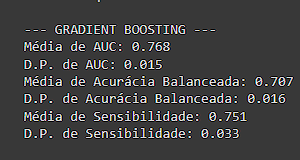

In [ ]:
# Quantidade de folds
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)

In [ ]:
# Métricas de interesse
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}

In [ ]:
# modelo_final = GridSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_jobs = -1)
modelo_final = RandomizedSearchCV(melhor_modelo.estimator, modelos[melhor_algoritmo][1], cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123, n_jobs = -1)
modelo_final.fit(X_sample_transformed, y_sample)

print(f"Melhores hiperparâmetros para {melhor_algoritmo}: {modelo_final.best_params_}")

Melhores hiperparâmetros para GRADIENT BOOSTING: {'n_estimators': 40, 'min_samples_leaf': 45, 'max_depth': 9, 'learning_rate': 0.03}


Os Melhores hiperparâmetros para o algoritímo são: {'n_estimators': 40, 'min_samples_leaf': 45, 'max_depth': 9, 'learning_rate': 0.03}

### Importância das features do modelo final

Aqui irei utilizar o Gini e o Shap para explicabilidade do modelo

In [ ]:
# Auxiliar: nomes das features após pré-processamento
features_qualitativas = X_sample.select_dtypes(include = ['object', 'category']).columns
features_qualitativas = pre_processamento.named_transformers_['cat'].get_feature_names_out(features_qualitativas) if not features_qualitativas.empty else features_qualitativas
features_quantitativas = X_sample.select_dtypes(include = ['int64', 'float64']).columns
features = list(features_qualitativas) + list(features_quantitativas)

In [ ]:
# Cálculo de medida de importância de Gini
importancias = modelo_final.best_estimator_.feature_importances_

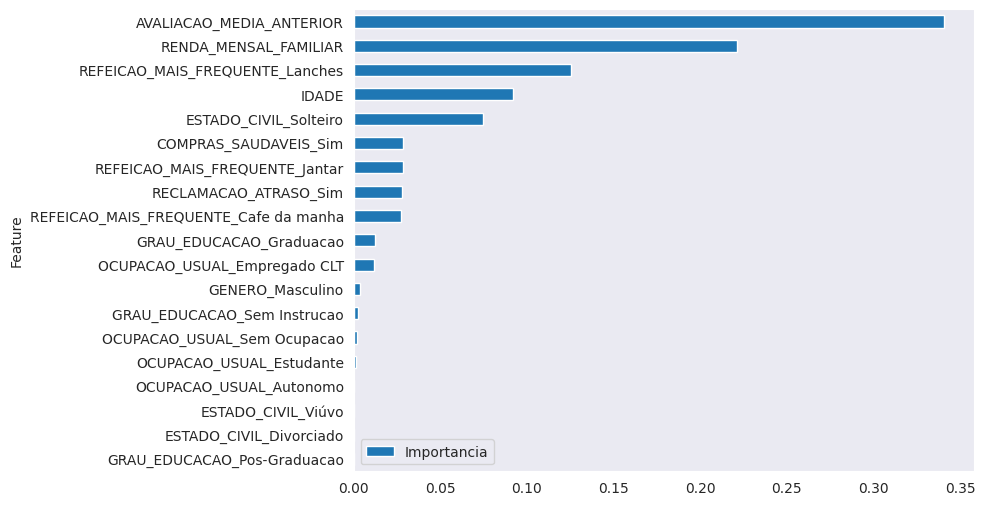

In [ ]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [ ]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(modelo_final.best_estimator_)
valores_shap = explainer(X_sample_transformed)

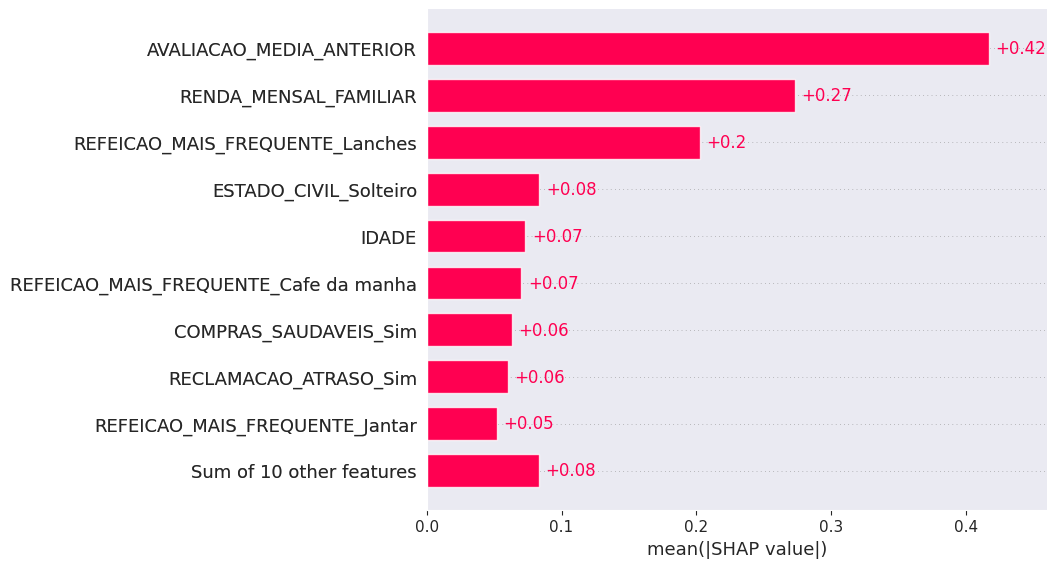

In [ ]:
# Gráfico do SHAP absoluto médio por feature
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.plots.bar(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.plots.bar(shap.Explanation(values = valores_shap, feature_names = features))

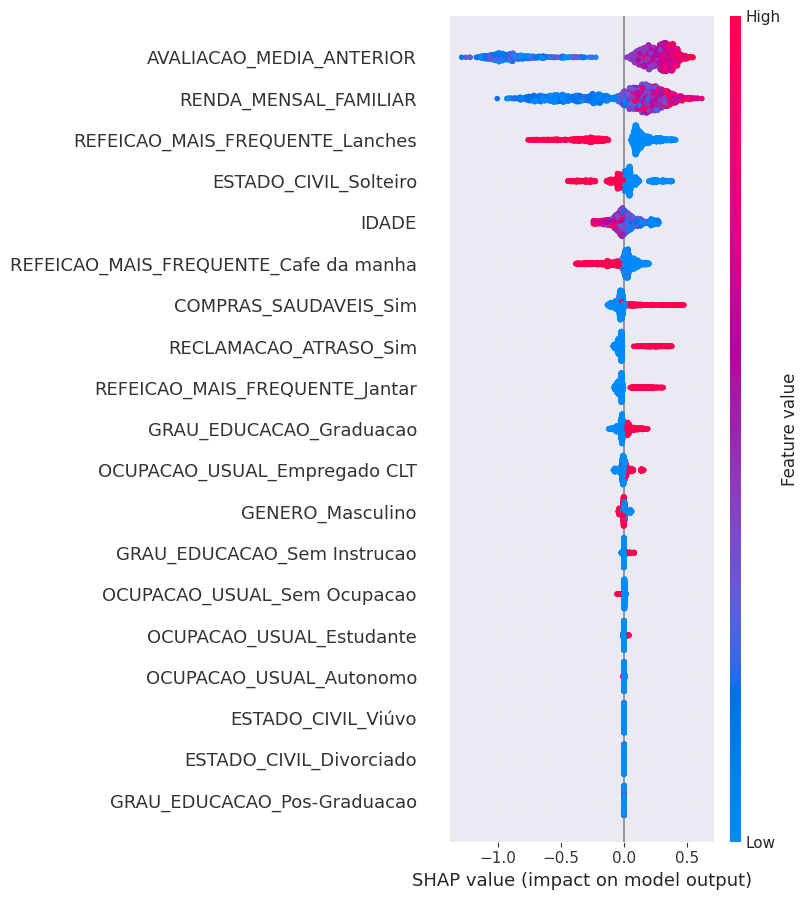

In [ ]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
if melhor_algoritmo == 'ÁRVORE DE DECISÃO' or melhor_algoritmo == 'FLORESTA ALEATÓRIA':
  shap.summary_plot(shap.Explanation(values = valores_shap[:,:,0], feature_names = features))
else:
  shap.summary_plot(shap.Explanation(values = valores_shap, feature_names = features))

### Aplicação de modelo final na base completa (caso tenha havido redução da base para a modelagem)


Por fim irei aplicar o melhor algoritmo e os melhores hiperparâmetros identificados anteriormente para a base completa

In [ ]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = modelo_final.best_estimator_.predict_proba(X_transformed)[:,1]

In [ ]:
# Definição de ponto de corte
ponto_corte = y_sample.astype(int).mean()

In [ ]:
# Atribuição da categoria predita
dados['y_pred'] = (y_prob >= ponto_corte).astype(int)

In [ ]:
# Tabela de classificação: real vs. predito (frequências absolutas)
pd.crosstab(y, dados['y_pred'])

y_pred,0,1
INFLUENCIADO_POR_NOTA,,
0,632,238
1,443,1431


In [ ]:
# Tabela de classificação: real vs. predito (frequências relativas)
pd.crosstab(y, dados['y_pred'], normalize = 'index').round(3) * 100

y_pred,0,1
INFLUENCIADO_POR_NOTA,,
0,72.6,27.4
1,23.6,76.4


### CONCLUSÕES FINAIS

A melhor solução de modelo de machine learning para identificação se são inflienciados ou não pela nota (variável alvo "INFLUENCIADO_POR_NOTA") é:

- Algoritmo: GRADIENT BOOSTING, baseado no seu melhor desempenho de AUC e para complementar, também tivemos um desempenho muito parecido na acurácia e na sensibilidade, em relação aos demais algorítmos.

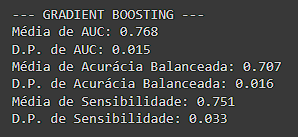
- Os melhores hiperparâmetros: n_estimators: 40, min_samples_leaf: 45, max_depth: 9, learning_rate: 0.03

image.png

Identificando as Top 5 variáveis mais importantes utilizando os métodos:

- Gini: AVALIACAO_MEDIA_ANTERIOR, RENDA_MENSAL_FAMILIAR, REFEICAO_MAIS_FREQUENTE_Lanches, IDADE, ESTADO_CIVIL_Solteiro
- Shap: AVALIACAO_MEDIA_ANTERIOR, RENDA_MENSAL_FAMILIAR, REFEICAO_MAIS_FREQUENTE_Lanches, ESTADO_CIVIL_Solteiro, IDADE

Observando as distribuições das top 5 variáveis mais importantes, utilizando Shap, podemos verificar o quanto cada variável influênciou positivamente, aumentando a probabilidade e o quanto influênciou negativamente, diminuindo a probabilidade.

Falando da variável mais importante, "AVALIACAO_MEDIA_ANTERIOR", podemos observar que, quanto maior a avalição, mais impacta positivamente nas probabilidades e quanto menor a avaliação, mais impacta negativamente.

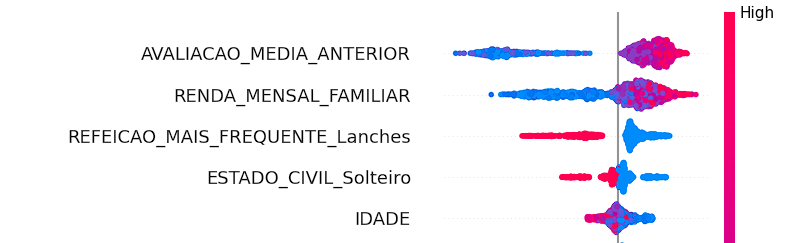